In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf

In [2]:
#%pip install unbinned-unfold==0.1.8
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: unbinned-unfold
    Found existing installation: unbinned_unfold 0.1.7
    Uninstalling unbinned_unfold-0.1.7:
      Successfully uninstalled unbinned_unfold-0.1.7
Note: you may need to restart the kernel to use updated packages.


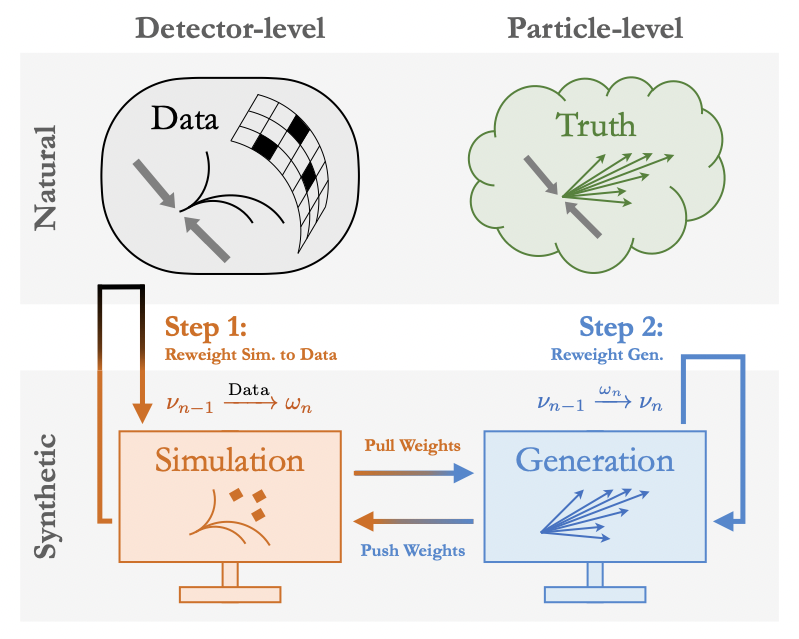

In [3]:
Image(filename='Omnifold.png')

In [4]:
def detector(x,std = 0.5):
    """ Create a fake detector response that smears the inputs given a gaussian distribution with mean 0 and std"""
    return x + np.random.normal(size=x.shape)*std

In [5]:
nevts = 1_000_00 #Number of training events we are going to use
ndim = 4 #Number of features we are going to create

In [6]:
gen_data = np.random.normal(size=(nevts,ndim),loc=ndim*[0.0],scale=ndim*[1.0])
reco_data = detector(gen_data)
gen_mc = np.random.normal(size=(nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
reco_mc = detector(gen_mc)

data = DataLoader(reco = reco_data,normalize=True)
mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


## Let's take a quick look at the data

(<Figure size 900x900 with 1 Axes>,
 <Axes: xlabel='First Feature [a.u]', ylabel='Normalized number of events'>)

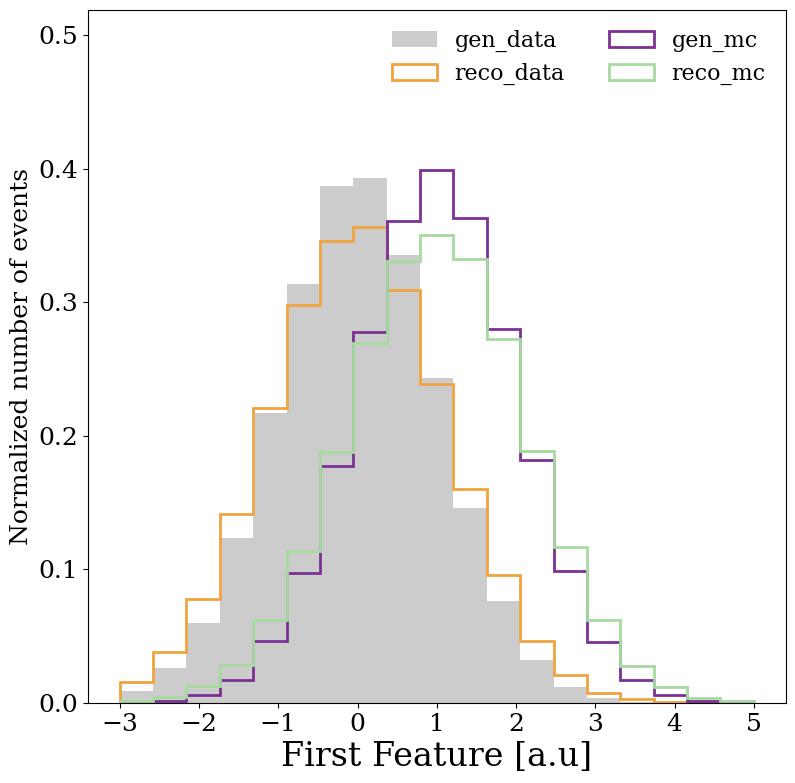

In [7]:
SetStyle()
data_dict = {
    'gen_data': gen_data[:,0],
    'reco_data': reco_data[:,0],
    'gen_mc': gen_mc[:,0],
    'reco_mc': reco_mc[:,0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'gen_data',plot_ratio=False, binning = np.linspace(-3,5,20))

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
model1 = MLP(ndim, layer_sizes = [16,32,16], activation = 'gelu')
model2 = MLP(ndim)

In [9]:
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
None


## Let's now unfold!

In [10]:
omnifold = MultiFold(
    "Gaussian_test",
    model1,
    model2,
    data,
    mc,
    batch_size = 1024,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = False,
)

In [11]:
omnifold.Preprocessing()
omnifold.Unfold()

195 training steps at reco and 195 steps at gen
ITERATION: 1
RUNNING STEP 1
Last val loss 5.930002212524414
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 5.52880859375
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1
Last val loss 10.400952339172363
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 3.7676002979278564
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss 7.8439555168151855
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 3.561384439468384
INFO: Dumping training history ...
ITERATION: 4
RUNNING STEP 1
Last val loss 7.4655914306640625
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 3.5464026927948
INFO: Dumping training history ...
ITERATION: 5
RUNNING STEP 1
Last val loss 7.38385009765625
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 3.565988540649414
INFO: Dumping training history ...


## Now, let's evaluate the model!

In [12]:
validation_data = np.random.normal(size=(nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

In [13]:
print(unfolded_weights)

[0.11244613 0.11410489 0.00791787 ... 0.4747217  0.02869204 0.01734821]


## More plots!

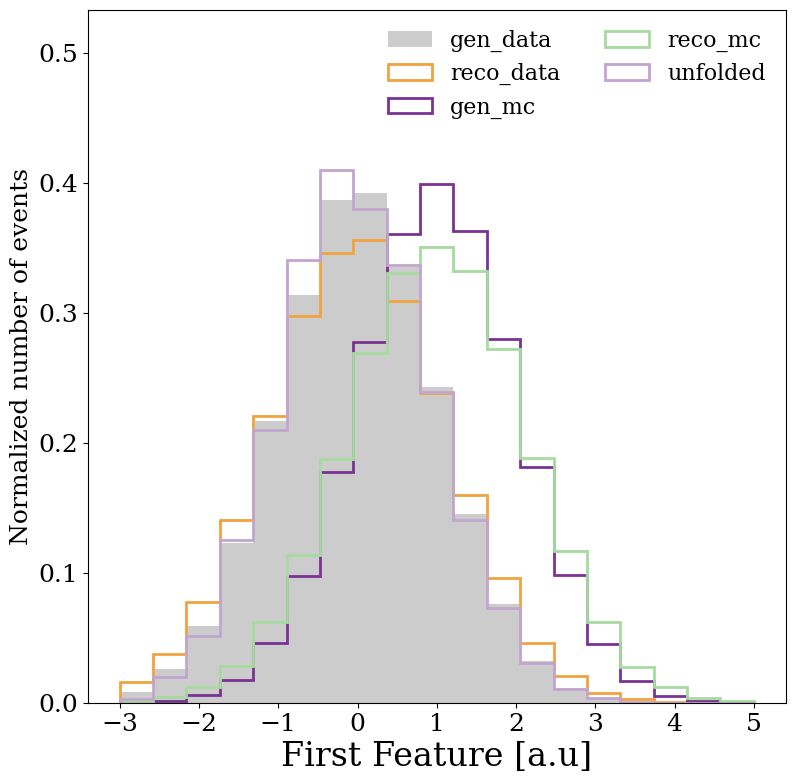

In [14]:
data_dict = {
    'gen_data': gen_data[:,0],
    'reco_data': reco_data[:,0],
    'gen_mc': gen_mc[:,0],
    'reco_mc': reco_mc[:,0],
    'unfolded': validation_data[:,0],
}

weight_dict = {
    'gen_data': data.weight,
    'reco_data': data.weight,
    'gen_mc': mc.weight,
    'reco_mc': mc.weight,
    'unfolded': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'First Feature [a.u]',
                    reference_name = 'gen_data',
                    weights = weight_dict,
                    plot_ratio = False,
                    binning = np.linspace(-3,5,20)
                    )
